<table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:300%;">
        Prediction of the area of the fire using the ForestFile dataset
    </h1></td>
    <td width="20%">
    <div style="text-align: right">
    <b> Machine Learning 2022</b> <br>
    Paola Maragno <br>
    <a href="mailto:paola.maragno@mail.polimi.it">paola.maragno@mail.polimi.it</a><br>
    </div>
    </td>
</tr>
</table>

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import scipy

np.random.seed(0)

In [8]:
# upload the 'forestfires.csv' dataset
fire = pd.read_csv("forestfires.csv")

# Exploratory data analysis and pre-processing step

In [3]:
# dimension of the dataset
fire.shape
# the dataset contains 517 observations (rows) and for each one there are 13 variables specified (columns)

(517, 13)

In [4]:
# visualize the data type of each variable of the dataset
fire.dtypes

X          int64
Y          int64
month     object
day       object
FFMC      object
DMC      float64
DC        object
ISI       object
temp      object
RH         int64
wind      object
rain     float64
area     float64
dtype: object

In [5]:
# I expected FFMC, DC, ISI, temp and wind to be quantitative variables. 
# Since they are reported to be strings I suppose they contain 'Missing' values.
# To check it:
fire[fire['FFMC'] == 'Missing']
# same reasoning for DC, ISI, temp and wind variables

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
461,8,6,aug,sat,Missing,231.1,715.1,8.4,18.9,64,4.9,0.0,0.0


In [6]:
# in case there are a lot of missing values it is better to avoid removing all the 
# rows that contain a missing value, while it is wiser to substiture the 
# missing values with, for example, the value of that variable in the next row.
# So first of all I counted how many missing values are present in the dataset:

fire = fire.replace('Missing',np.nan)

fire.isnull().sum().sum()

7

In [7]:
# since there are only 7 missing values I can remove the rows that contain them

fire = fire.dropna()

In [8]:
fire.shape

(510, 13)

In [9]:
# I then casted the string variables in float type
fire = fire.astype({"FFMC": float})
fire = fire.astype({"DC": float})
fire = fire.astype({"ISI": float})
fire = fire.astype({"wind": float})
fire = fire.astype({"temp": float})

In [10]:
fire.dtypes

# once I removed the missing values the only variables of object type are month and day, as expected

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

In [11]:
fire.describe().T
# summary of the main descriptive statistics of the quantitative variables of the dataset.
# There is a great difference in the scale of the different variables: some, like X, Y, wind and rain have 
# a very low mean value. ISI, temp, RH and area have a medium mean; while FFMC, DMC and DC are in high scale

,count,mean,std,min,25%,50%,75%,max
X,510.0,4.650980,2.314163,1.0,3.000,4.000,7.0000,9.00
Y,510.0,4.298039,1.232100,2.0,4.000,4.000,5.0000,9.00
FFMC,510.0,90.635686,5.552774,18.7,90.200,91.600,92.9000,96.20
DMC,510.0,110.812157,64.103740,1.1,68.875,108.300,142.1250,291.30
DC,510.0,547.918627,248.667923,7.9,434.400,664.200,713.9000,860.60
ISI,510.0,9.017059,4.571755,0.0,6.500,8.400,10.7750,56.10
temp,510.0,18.880196,5.820904,2.2,15.500,19.300,22.8000,33.30
RH,510.0,44.350980,16.359792,15.0,33.000,42.000,53.0000,100.00
wind,510.0,4.008824,1.793894,0.4,2.700,4.000,4.9000,9.40
rain,510.0,0.021961,0.297976,0.0,0.000,0.000,0.0000,6.40


array([[<AxesSubplot:title={'center':'X'}>,
        <AxesSubplot:title={'center':'Y'}>,
        <AxesSubplot:title={'center':'FFMC'}>],
       [<AxesSubplot:title={'center':'DMC'}>,
        <AxesSubplot:title={'center':'DC'}>,
        <AxesSubplot:title={'center':'ISI'}>],
       [<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'RH'}>,
        <AxesSubplot:title={'center':'wind'}>],
       [<AxesSubplot:title={'center':'rain'}>,
        <AxesSubplot:title={'center':'area'}>, <AxesSubplot:>]],
      dtype=object)

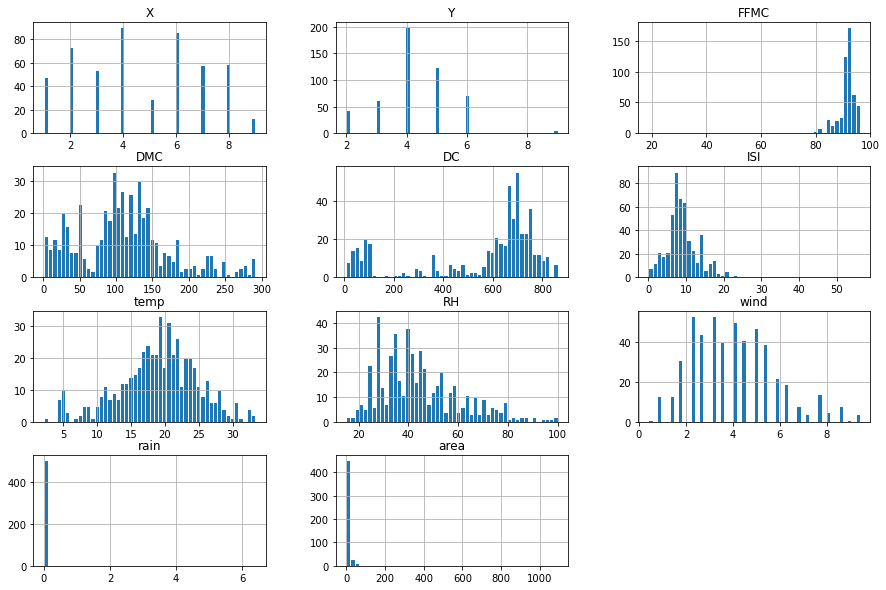

In [12]:
# to visualize the distribution of the 11 numerical variables of the dataset I plotted the histogram
# of each of them
fire.hist(bins=50, figsize=(15,10), ec='w')
plt.show()

In [9]:
# from the histogram of the single quantitative variables present in the dataset I noticed that FFMC, ISI, rain and area
# have a few extreme points (outliers).

# from the distribution of the variable 'area' it's clear that the majority of the fires present a small size and
# just a few observations have a high burnt area. 
# To improve symmetry it is better to do the logarithmic transformation of this variable:
fire['log_area'] = np.log1p(fire['area'])

In [10]:
# remove the original 'area' feature
fire = fire.drop(['area'],axis=1)

(517, 14)

(517, 13)

<AxesSubplot:>

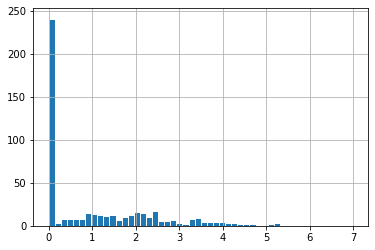

In [15]:
fire['log_area'].hist(bins=50, ec='w')
plt.show()

After the logarithmic tranformation, variable log_area shows values that are distributed in a smaller range but still we can see that more or less half of the observations have value 0 and only a few of them reach high values. So the distribution is still strongly asymmetric.

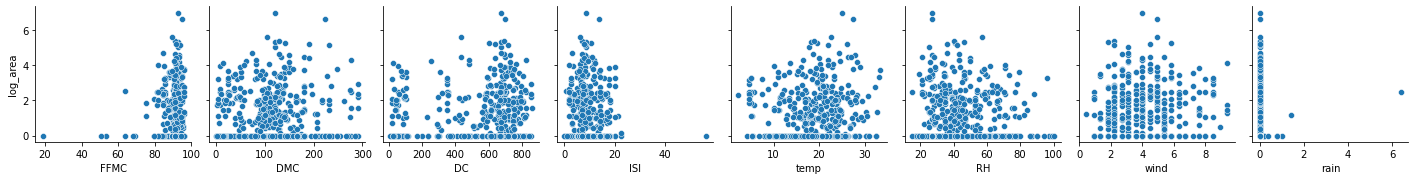

In [16]:
plt.rcParams["figure.figsize"] = 10,5

fire2 = fire.copy()
fire2 = fire2[['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain','log_area']]
# I first created a copy of fire dataset removing the categorical variables.
# Then I plotted the scatterplot of log_area against each possible variable to see whether they appear correlated somehow
sns.pairplot(fire2, x_vars = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'], y_vars=['log_area'], height=2.5)

FMMC-log_area: all the FFMC values are high so there not seems to be a particular trend of the dimension of fire area depending on FFMC.
DMC-log_area: higher fire area have medium value of DMC.
DC-log_area: higher fire area have high value of DC but in general there not seems to be a particular behaviour of the fire area depending on the DC value.
ISI-log_area: all the ISI value are between 0 and 20, there is only an outlier value near 60.
temp-log_area: I can see that for the observations in which the area is bigger the temperature is quite high, surely higher than the median value of this variable. 
RH-log_area: higher fire area have low value of RH, but in general there not seems to be a particular trend of the fire area depending on the RH value.
wind-log_area: I can see that for the observations in which the area is bigger the wind is not the highest but it has medium value. In general it doesn't seem to be a trend of the area of the fire depending on the wind since for each of the different scale of area more or less all the wind values have been observed.
rain-log_area: almost all the observations have a value of rain equal to 0. What is important to notice is that the only observations with a value of rain bigger than 1.5 have higher area of fire.

In conclusion, there not seems to be a clear linear correlation between log_area and other variables.

In [17]:
# I replace the categorical variables month and day with values from 1 to 12 and from 1 to 7, respectively, so that I can represent
# the fact that January is closer to February than to September, for example. While Monday is closer to Tuesday than to Friday,
# for example
fire['month'] = fire['month'].replace(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],range(1,13))
fire['day'] = fire['day'].replace(['mon','tue','wed','thu','fri','sat','sun'],range(1,8))


In [18]:
print('months', fire.month.value_counts(), sep='\n')

months
8     180
9     171
3      53
7      32
2      20
6      17
10     14
4       9
12      9
1       2
5       2
11      1
Name: month, dtype: int64


The majority of the fires happened in August and September

In [19]:
print('day', fire.day.value_counts(), sep='\n')

day
7    93
5    84
6    81
1    73
2    64
4    61
3    54
Name: day, dtype: int64


The majority of the fires occured during the weekend

<AxesSubplot:xlabel='month', ylabel='log_area'>

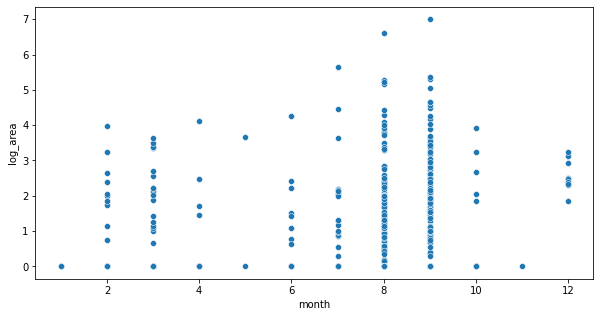

In [20]:
sns.scatterplot(data=fire, x='month', y='log_area')

It's visibile that the majority of the fires happened in August and September.
The two highest values of burnt area happened in these two months, but except for these two observations low and high value of log_area are reported in the same way in all the month. 
Consequently, I don't expect month to be a variable important to predict the dimension of the burnt area.

<AxesSubplot:xlabel='day', ylabel='log_area'>

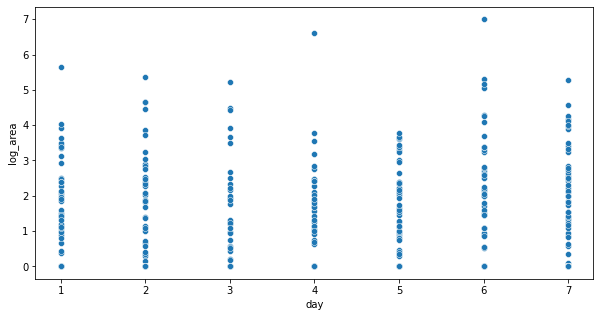

In [21]:
sns.scatterplot(data=fire, x='day', y='log_area')

It is clear that bigger fires occured in the same way in all the days of the week, suggesting that also this variable is not expected to be relevant for the prediction of the dimension of the burnt area

<AxesSubplot:xlabel='month', ylabel='temp'>

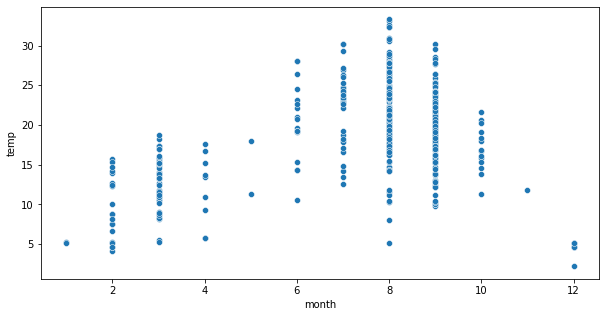

In [22]:
sns.scatterplot(data=fire, x='month', y='temp')

July, August and September are the months in which the temperature reaches higher values

<AxesSubplot:xlabel='day', ylabel='temp'>

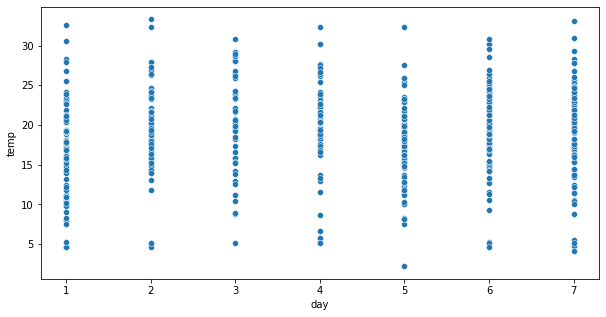

In [23]:
sns.scatterplot(data=fire, x='day', y='temp')

Temperature is distributed in the same way in different days of the weak

<AxesSubplot:xlabel='month', ylabel='rain'>

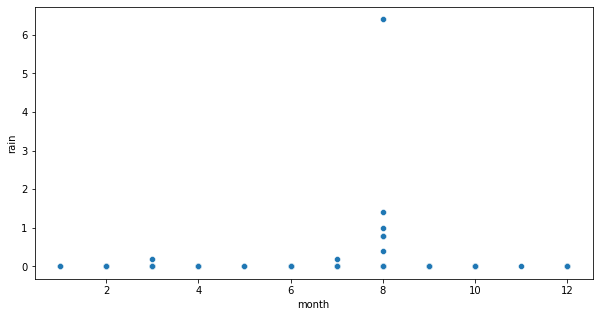

In [24]:
sns.scatterplot(data=fire, x='month', y='rain')

In general very few rain events have been observed, almost all of them in August

<AxesSubplot:xlabel='month', ylabel='wind'>

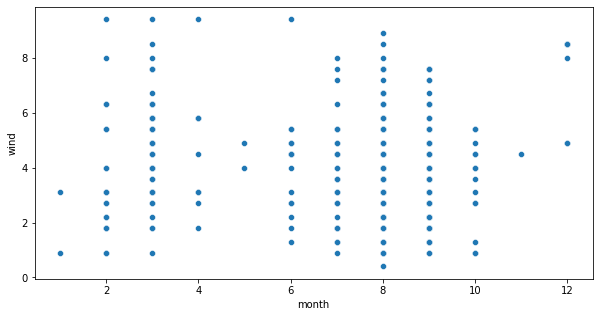

In [25]:
sns.scatterplot(data=fire, x='month', y='wind')

Wind doesn't have a particular distribution depending on the months in which the fire occured: high and low values of wind have been observed more or less in all the months.

<AxesSubplot:xlabel='day', ylabel='wind'>

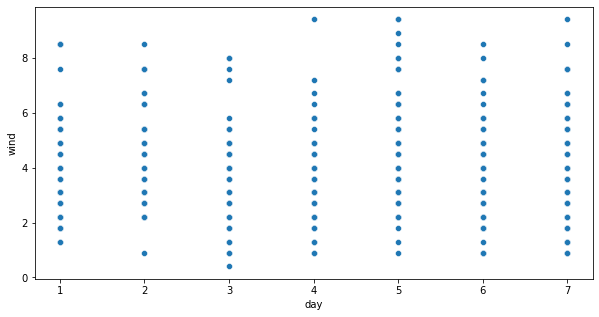

In [26]:
sns.scatterplot(data=fire, x='day', y='wind')

Wind has quite the same distribution in the different days of the week

All the previous scatterplots between month or day and a different variable (I chose only some of the variables that I thought may change during the different months) are not very significative since months belong to different years while days belongs to weeks of different months and/or years. Consequently looking at the trend of a variable on respect to months that are actually of different years is not significant since even considering the same month the observations that are reported in the scatterplot come from months of different years

# Linear regression

In [27]:
X_features = fire.columns.to_list()
# list of all the features in the fire dataset 
X_features.remove('log_area')

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# definition of X dataset, made of the values of the different X covariates, for the 510 observations
X = fire[X_features].to_numpy()
y = fire['log_area'].to_numpy()
print("X.shape ", X.shape)
print("y.shape ", y.shape)

fire_test_size = 0.3
# the test set will contain the 30% of the total observations present in the original fire dataset
fire_test_seed = 40
# Split X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=fire_test_size, random_state=fire_test_seed)
print("X_train.shape ", X_train.shape)
print("X_test.shape ", X_test.shape)


model = LinearRegression(fit_intercept=True) 
# first I created the linear regression model object
model = model.fit(X_train, y_train) 
# than I fitted the model using the observations of the train set

# once the model was fitted I used it to predict the area of the observations of the test set
# giving as input the values of the variables of these observations, excluding the value
# of their log_area since it is what I wanted to predict
y_predict_test = model.predict(X_test)
y_predict_train = model.predict(X_train)

print("Train R2 score ", r2_score(y_train, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train, y_predict_train))
# error of the fitted model on the training set

print("Test R2 score ", r2_score(y_test, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test, y_predict_test))
# error of the fitted model on the test set

X.shape  (510, 12)
y.shape  (510,)
X_train.shape  (357, 12)
X_test.shape  (153, 12)
Train R2 score  0.03668203270214054
Train MSE score  1.8555244360196985
Test R2 score  0.009942320601879162
Test MSE score  2.0208956896937025


The R2 scores on both the train and the test set are very low: this suggests that this model is not very good since the proportion of the total variability of the data that the model is able to explain is the 3.7% in the train set and the 1% in the test set. 

In [29]:
# beta coefficients of the model fitted on the train set
for idx, col_name in enumerate(X_features):
    print("The coefficient for {} is {}".format(col_name, model.coef_[idx]))
print("The intercept is {:0.3f}".format(model.intercept_))

The coefficient for X is 0.04347725360028954
The coefficient for Y is 0.03388147225309197
The coefficient for month is 0.10312115752347539
The coefficient for day is 0.03589182518974683
The coefficient for FFMC is 0.013881445186857086
The coefficient for DMC is -0.00012085770495529752
The coefficient for DC is -0.00047018313748525137
The coefficient for ISI is -0.023654626268406143
The coefficient for temp is 0.0011352784391768732
The coefficient for RH is 0.00018294210528416437
The coefficient for wind is 0.07966811139125471
The coefficient for rain is 0.11774454292508382
The intercept is -1.282


In [30]:
from scipy.stats import t, f

# I used the functions defined in the second laboratory of ML to compute different
# statistics that can be used to assess the quality of the just fitted model

# definition of a function to cumpute the residual sum of squares as the sum of the squared difference between
# the true response and the predicted one
def rss(y_true, y_pred):
    y_true = y_true.reshape(y_pred.shape)
    return np.sum((y_true - y_pred) ** 2)

# definition of a function to compute the total sum of squares as the sum of the squared difference
# between the true y values and the mean of the true y values
def tss(y):
    return np.sum((y - y.mean()) ** 2)

# definition of a function that creates the linear regression model object, fits it on the 
# X and y set and then returns the y values predicted using the X observations and the list of
# beta coefficients of the just fitted model
def multiple_least_squares(X, y):
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)
    betas = [model.intercept_, *model.coef_]
    return betas, y_pred

# definition of a function that computes t-statistics for the coefficients
def show_stats(X, y, betas, names, alpha=None):
    n_samples, n_features = X.shape
    deg = n_samples-n_features
    
    # in case the ones column has not been added it is added with the following code
    if X.shape[1] + 1 == betas.shape[0]:
        X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=-1)
    
    pred = X.dot(betas).reshape(-1)
    betas = betas.reshape(-1)
    y = y.reshape(-1)
    RSE = ((y-pred)**2).sum()/(n_samples - n_features)
    # residual standard error is computed as the ratio between the RSS and the degree

    # to compute the t-statistics first of all the variance is computed, then the standard 
    # deviation and eventually the t-statistics
    se2_b = RSE*(np.linalg.inv(np.dot(X.T, X)).diagonal())
    se_b = np.sqrt(se2_b)
    t_stat_b = (betas - 0) / se_b

    # Compute the p-value
    p_values = np.array([2*t.sf(np.abs(t_stat), deg) for t_stat in t_stat_b])
    
    df = pd.DataFrame()
    df["Name"] = names
    df["Coefficients"] = betas
    df["Standard Errors"] = se_b
    df["t-stat"] = t_stat_b
    df["p-value"] = p_values
    if alpha:
        rejectH0 = p_values < alpha
        df["reject H0"] = rejectH0    
    
    RSS = np.sum((y - pred)**2)
    MSE = RSS/y.shape[0]
    print("RSS: {}".format(RSS))
    
    return df

In [31]:
# perform the t-test on each coefficient of the fitted linear model:
# H0: there is no relation between the variable X and Y
# H1: there is some relation between X and Y
betas = np.array([model.intercept_, *model.coef_]).reshape(-1, 1)
show_stats(X_train, y_train, betas, ['Intercept', *X_features], alpha=0.05)

RSS: 662.4222236590324


,Name,Coefficients,Standard Errors,t-stat,p-value,reject H0
0,Intercept,-1.282032,1.523741,-0.841372,0.400723,False
1,X,0.043477,0.037446,1.161065,0.246418,False
2,Y,0.033881,0.072630,0.466493,0.641157,False
3,month,0.103121,0.072900,1.414550,0.158102,False
4,day,0.035892,0.036561,0.981709,0.326931,False
5,FFMC,0.013881,0.015240,0.910854,0.363008,False
6,DMC,-0.000121,0.001953,-0.061894,0.950683,False
7,DC,-0.000470,0.000850,-0.553004,0.580619,False
8,ISI,-0.023655,0.018824,-1.256628,0.209738,False
9,temp,0.001135,0.021546,0.052690,0.958009,False


With the previous function I tested the significance of each coefficient independently from the others, and so the effect of each variable on the output predicted by the model without considering that at the same time there are other variables that can have an effect on the output.
The result shows that there isn't any coefficient that, with a level of significance of 0.05, is significantly  different from 0.

In [32]:
# compute the list of coefficients of the model fitted on the train set and the predicted response using the previous 
# defined function
betas, y_pred = multiple_least_squares(X_train, y_train)

n = X_train.shape[0]
nf = X_train.shape[1]

# Compute RSS and TSS using the previous defined functions
rss = rss(y_train, y_pred)
tss_y = tss(y_train)

# H0: all the coefficients are equal 0;
# H1: at least one coefficient is different from 0.

# Compute the nominator of the F statistics as the difference between the TSS and RSS divided by the number of 
# features of the model
F_num = (tss_y - rss) / nf
# compute the denominator of the F statistics as the RSS divided by the difference between the 
# number of observations of the train test and the number of features -1
F_den = rss / (n - nf - 1)
F = F_num / F_den

# Compute the p-value knowing that F statistics follows a Fisher distribution
p_value = f.sf(F, nf, n - nf - 1)

print("F-stat: ", F)
print("p-value: ", p_value)


F-stat:  1.0915934715488271
p-value:  0.36602935972425626


In our case we obtained an F-statistics of 1.09: being very close to 1 it means that there isn't any coefficient different from 0.
In fact the p-value is 0.37 meaning that, choosing a level of significance alpha = 0.05, 
the H0 hypothesis can't be rejected and so I can't say that at least one coefficient of this
linear regression model is different from 0. 

F statistic is more accurate than t statistic computed for each parameter since it corrects for the other parameters: in t-test you are  computing the usefulness of a parameter without the others, while in F-test you are evaluating the usefulness of a parameter when the others are present.

## Polynomial regression 

In [33]:
fire_test_seed_v3=41
X_trainP, X_val, y_trainP, y_val = train_test_split(X_train, y_train, 
                                                    test_size=y_test.shape[0],
                                                    random_state=fire_test_seed_v3)

In Polynomial regression the validation set, instead of the test set, is used to compute the performance of the model depending on the different degrees.
By the end the best degree parameter found on the validation set is used to train the model on the train set. Eventually the performance of the model with the best degree is computed on the test set.

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

degree = list(range(1,5))
test_scores = np.zeros(len(degree))
val_scores = np.zeros(len(degree))
train_scores = np.zeros(len(degree))

# Validation
for i, d in enumerate(degree):
    # for each degree I compute the Poly object 
    model = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                      ('linear', LinearRegression(fit_intercept=True))])
    # the model object is fitted on the train set
    model = model.fit(X_trainP, y_trainP)
    
    # the fitted model is evaluated on the validation test
    y_predict = model.predict(X_val)
    val_score = r2_score(y_val, y_predict)
    # the fitted model is evaluated on the test test
    y_predict = model.predict(X_test)
    test_score = r2_score(y_test, y_predict)
    # the fitted model is evaluated on the train test
    y_predict = model.predict(X_trainP)
    train_score = r2_score(y_trainP, y_predict)
    
    # the just computed scores of the model with degree d on the validation, test and train set
    # are saved into the corresponding list to keep track of them 
    val_scores[i] = val_score
    test_scores[i] = test_score
    train_scores[i] = train_score

# identification of the best validation score and of the corresponding degree
best_model_idx = np.argmax(val_scores)
best_degree = degree[best_model_idx]
best_val_score = val_scores[best_model_idx]
print("Best degree: ", best_degree,
      "\nVal score: ", best_val_score)
    
# Train again the Pipeline using the best degree parameter and the whole training set
model = Pipeline([('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

model = model.fit(X_train, y_train)
# compute the performance of the model on the test set
y_predict = model.predict(X_test)
test_score = r2_score(y_test, y_predict)

print("Test score:", test_score)

Best degree:  1 
Val score:  -0.10812470406214358
Test score: 0.009942320601879162


From this analysis we can see that the degree of the best model is 1, meaning that the linear regression model is better than every possible polynomial model with degree higher than 1 (even if the linear regression model with degree 1 is anyway not good since the r2 score is very low)

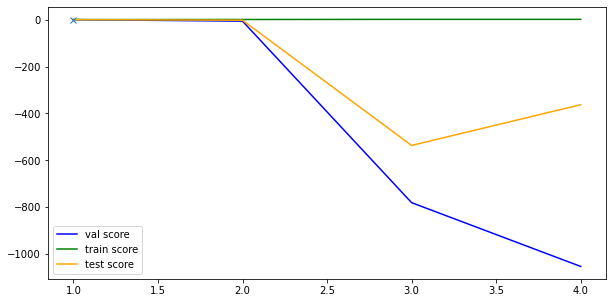

In [35]:
_ = plt.plot(degree,val_scores, label="val score", color="blue")
_ = plt.plot(degree, train_scores, label="train score", color="g")
_ = plt.plot(degree, test_scores, label="test score", color="orange")
_ = plt.plot([best_degree], [best_val_score], marker="x")
plt.legend()

## Cross validation: k-fold cross-validation

Cross Validation is performed in this way: first all data are divided in training data and test data.
Then the train set is splitted k times in k parts: each time k-1 parts are used as train set to fit a model while the remaining one as validation set. The validation set is used as a test set to compute a performance measure of the model fitted on the train set.
The overall validation score is the average score on all the validation sets.

Cross Validation is used to compare models with different complexity and then select the model for which the resulting estimated test error is the smallest. 
This procedure has the advantage to provide a direct estimate of the test error needing fewer assumptions about the true underlying model.

The GridSearchCV class performs cross validation while also searching among a set of different hyperparameters.

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# compute the Poly object that is made of the polynomial features of the original features    
model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

r2_scorer = make_scorer(r2_score,
                        greater_is_better=True)

# Select parameters to optimize
parameters = {'poly__degree': list(range(1,5))}

# GridSearchCV function computes the cross validation on the model, that can be either linear or 
# polynomial, using as scoring function the one that computes the r2, cv is the number of k-fold
# the function must perform, while parameters are those that the function has to try in training the 
# model
cv = GridSearchCV(model, parameters, scoring=r2_scorer, cv=5, refit=True)
cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(degree=1,
                                                           include_bias=False)),
                                       ('linear', LinearRegression())]),
             param_grid={'poly__degree': [1, 2, 3, 4]},
             scoring=make_scorer(r2_score))

In [37]:
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001183,0.000501,0.000274,0.000061,1,{'poly__degree': 1},-0.064189,-0.107366,-0.027227,-0.307115,-0.037100,-0.108600,0.103069,1
1,0.002199,0.000503,0.000378,0.000073,2,{'poly__degree': 2},-1.190160,-1.415218,-3.600056,-2.144032,-0.660054,-1.801904,1.017643,2
2,0.016389,0.001408,0.000562,0.000020,3,{'poly__degree': 3},-11455.500265,-1121.121139,-1508.884379,-3010.144294,-981.803551,-3615.490725,3985.678661,4
3,0.029673,0.005560,0.000910,0.000280,4,{'poly__degree': 4},-178.819943,-421.378213,-1381.567090,-373.505497,-726.263204,-616.306789,420.965105,3


In [38]:
# Retrieve the best **trained** estimator
cv.best_estimator_
# Retrieve its parameters
cv.best_params_
# Retrieve the best **CV** score
# I.e., mean of the scores on each fold
cv.best_score_

Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('linear', LinearRegression())])

{'poly__degree': 1}

-0.10859950081537799

In [39]:
model = cv.best_estimator_
y_predict = model.predict(X_test)
test_score = r2_score(y_test, y_predict)

print("Best degree:", cv.best_params_['poly__degree'])
print("Train score:", cv.best_score_)
print("Test score:", test_score)

Best degree: 1
Train score: -0.10859950081537799
Test score: 0.009942320601879162


With GridSearch I obtained the same result as before: the best model is the one with degree 1 even if the r2 score on the test set is very low.

# Feature selection

Exhaustive exploration (F-test) can be used to tell if a variable is useful or not to predict the output: the problem of F-test is that you have to test all the possible combinations to find the subset of variables useful to build a model.
In case you have p variables the number of models you have to test is 2^p and so the procedure becomes too much complex.

There are different other techniques to do feature selection: some are better to improve prediction accuracy other to improve the model interpretability.

Best subset selection requires to test all the possible combinations of p features: since in this case we have p=12 variables, the complexity of this procedure, 2^12, doesn't allow to perform it. 

## Forward stepwise feature selection

Forward stepwise feature selection first of all builds all the models with one feature: between them it chooses the one with the best R2 score.
Starting from this one-feature model, the algorithm adds another feature: from the set of models with two features (where the first one is fixed) it chooses the best model as the one with the highest r2 score.
The function procedes in this way producing a list of models that are the best ones with 1 till p features.
To choose the best model between those with a different number of predictors, and so different complexity, the BIC score of the model on the train set must be used.

In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer

# definition of serie of functions needed to perform forward feature selection

# the evaluator function is required to train a model and evaluate it against 
# a specific training set
def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
            # if the model is not trained it trains your data
        score = scorer(model, X, y)
        return model, score
    return evaluator   

def get_sigma_scorer(metric, sigma):
    def scorer(model, X, y):
        n, d = X.shape
        y_pred = model.predict(X)
        return metric(y_pred, y, n, d, sigma)
    
    return scorer

def bic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + np.log(n)*d*sigma2) / (n*sigma2)

def rss(y_true, y_pred):
    y_true = y_true.reshape(y_pred.shape)
    return np.sum((y_true - y_pred) ** 2)

def estimate_sigma(Xtrain, ytrain):
    # Sigma is usually estimated using the model with all features
    n, p = Xtrain.shape
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain, ytrain)
    y_pred = model.predict(Xtrain)
    RSS = rss(y_pred, ytrain)
    RSE = np.sqrt(RSS / (n-p))
    return RSE

def forward_selection(Xtrain, ytrain, Xtest, ytest,
                      candidates_evaluator, candidates_argbest, 
                      subsets_evaluator, subsets_argbest,       
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  
                      subsets_scorer_name=None,     
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing the value of the best Mk model 
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    plt.figure()
    candidate_fig = plt.subplot(111) # A global matplotlib figure
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []  
    # list in which the selected features will be stored 
    all_features = Xtrain.columns
    
    # 1. Train M0
    # ===========
    model = DummyRegressor() # model M0 that assigns the mean of the target variable to each prediction
    
    model, score = candidates_evaluator(model, Xtrain[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    _ = candidate_fig.scatter([0], [score], color="b")
    
    _, score = subsets_evaluator(model, Xtrain[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain[[]], ytrain, trained=True)
    subsets_test.append(score)
        
   
    # 2. Evaluate all Mk candidates with
    #    k=0...P features
    for dim in range(num_features):
        candidate_metrics = [] # Keep track of candidates metrics
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Given the previous Mk model, test remaining
        # features and select the one providing the best
        # performance increment
        # ===============================================
        remaining_features = Xtrain.columns.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain[selected_features+[new_column]].to_numpy()
            model = LinearRegression(fit_intercept=True)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate in (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        # Compute metric 
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest[best_features].to_numpy()
        _, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim, best_features))
            print("M{} subset score (3.): {}".format(dim, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    # Plot a figure to show how te 3. metric evolves
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()
    

............
Best model (M0) with 0 features: ['wind']
M0 subset score (3.): 2.060657386004516
............
Best model (M1) with 1 features: ['wind', 'month']
M1 subset score (3.): 2.007685079077795
............
Best model (M2) with 2 features: ['wind', 'month', 'X']
M2 subset score (3.): 2.004914668599307
............
Best model (M3) with 3 features: ['wind', 'month', 'X', 'ISI']
M3 subset score (3.): 2.0052638495360764
............
Best model (M4) with 4 features: ['wind', 'month', 'X', 'ISI', 'FFMC']
M4 subset score (3.): 2.002178471398675
............
Best model (M5) with 5 features: ['wind', 'month', 'X', 'ISI', 'FFMC', 'day']
M5 subset score (3.): 2.015121953052077
............
Best model (M6) with 6 features: ['wind', 'month', 'X', 'ISI', 'FFMC', 'day', 'DC']
M6 subset score (3.): 2.010598488982886
............
Best model (M7) with 7 features: ['wind', 'month', 'X', 'ISI', 'FFMC', 'day', 'DC', 'rain']
M7 subset score (3.): 2.014172155474068
............
Best model (M8) with 8 fe

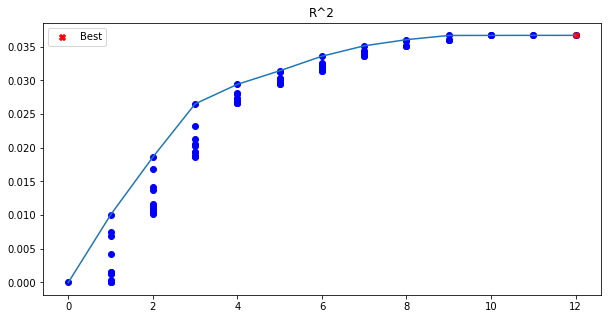

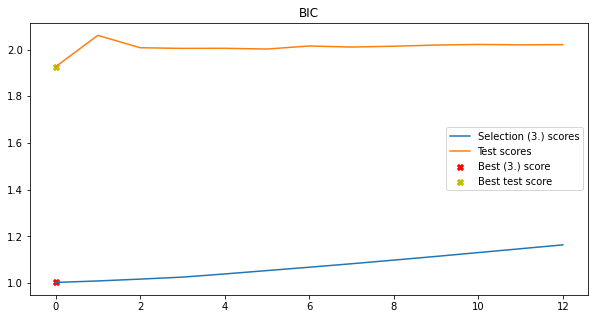

In [41]:
X = fire[X_features]
y = fire['log_area']

fire_test_size = 0.3
fire_test_seed = 40
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=fire_test_size, random_state=fire_test_seed)

sigma = estimate_sigma(X_train, y_train)

forward_selection(X_train, y_train, X_test, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax,
                  # estimate the test R^2 error to choose the best model among the ones with the same 
                  # complexity
                  get_evaluator(get_sigma_scorer(bic, sigma)), np.argmin, 
                  # estimate the test BIC error to choose the best model among the ones with different
                  # complexity
                  get_evaluator(make_scorer(mean_squared_error)), np.argmin, 
                  # estimate the test MSE to choose the best model among the ones with the same 
                  # complexity
                  candidates_scorer_name="R^2",
                  subsets_scorer_name="BIC",
                  verbose=True)


The best model according to forward feature selection is the one without any feature, so the dummy regressor - that assigns the mean of the target variable to each prediction without taking in consideration the input data -  is better than all the possible linear regression models fitted on the train set with different number of features. 
In fact in the last plot is visible that the number of features for which the BIC score is the minimum is 0.

## Forward Feature selection with Cross-validation

In this case Forward feature selection is applied by adding one variable at the time keeping all the previously selected ones fixed (choosing which variable to add comparing the r2 score of models with the same number of predictors). In addition, once the best model between all the models with a certain number of features has been found, Cross Validation is applied and returns the average validation score of the k scores computed on each validation set.
By the end, comparing the cross validation score of models with different number of features, the model with the number of features for which the Cross Validation score is the best one is returned as the best model.

............
Best model (M0) with 0 features: ['X']
M0 subset score (3.): -0.02821022689977215
............
Best model (M1) with 1 features: ['X', 'month']
M1 subset score (3.): -0.009925078004475951
............
Best model (M2) with 2 features: ['X', 'month', 'wind']
M2 subset score (3.): -0.010178600475705846
............
Best model (M3) with 3 features: ['X', 'month', 'wind', 'day']
M3 subset score (3.): -0.025193788874934953
............
Best model (M4) with 4 features: ['X', 'month', 'wind', 'day', 'FFMC']
M4 subset score (3.): -0.023714358569498106
............
Best model (M5) with 5 features: ['X', 'month', 'wind', 'day', 'FFMC', 'DMC']
M5 subset score (3.): -0.035696318110800096
............
Best model (M6) with 6 features: ['X', 'month', 'wind', 'day', 'FFMC', 'DMC', 'Y']
M6 subset score (3.): -0.03764034613832168
............
Best model (M7) with 7 features: ['X', 'month', 'wind', 'day', 'FFMC', 'DMC', 'Y', 'ISI']
M7 subset score (3.): -0.08566508441824183
............
Best m

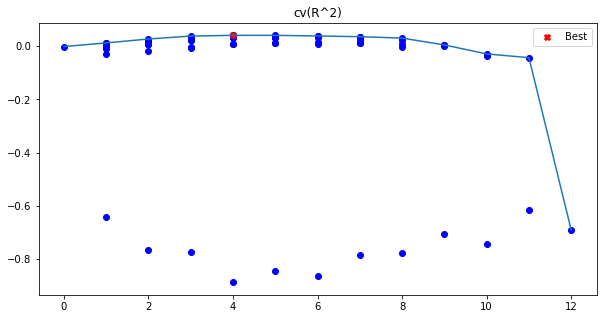

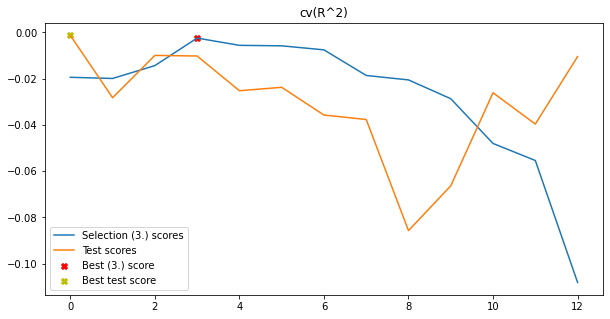

In [42]:
# definition of a recursive evaluator function that is formed by a nested function that
# splits the train set in a train and in a validation part, afterwords it fits the model 
# on the training subpart and computes the score applying the fitted model on the validation set.
# By the end the get_val_evaluator function returns the model and the validation score
def get_val_evaluator(scorer, val_size=0.3):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                          test_size=val_size,
                                                          random_state=fire_test_seed)
        
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val) 
        
        return model, score
    
    return evaluator

# using a cross evaluator we train the model each time we choose k-1 parts of the training data
# as training set and the remaining one as validation set 
def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator


sigma = estimate_sigma(X_train, y_train)
forward_selection(X_train, y_train, X_test, y_test,
                  get_val_evaluator(make_scorer(r2_score)), np.argmax, 
                  get_cv_evaluator(make_scorer(r2_score),cv =10), np.argmax,
                  get_val_evaluator(make_scorer(r2_score)), np.argmax,
                  candidates_scorer_name="cv(R^2)",
                  subsets_scorer_name="cv(R^2)",
                  verbose=True, weight_step3=10)


From the Forward Feature Selection procedure with Cross Validation the best model is the one with 3 features, ['X', 'month', 'wind'].
Its r2 score is 0 meaning that actually this model is not able to model the data in a good way.

I performed linear regression using the just selected set of features.

In [43]:
X_selected = ['X', 'month', 'wind']
X_small = fire[X_selected].to_numpy()
fire_test_seed_v2=40
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y,
                                                                test_size=fire_test_size, 
                                                                random_state=fire_test_seed_v2)

model = LinearRegression()                       
model = model.fit(X_train_small, y_train_small)        
y_predict_test = model.predict(X_test_small)     
y_predict_train = model.predict(X_train_small)


print("Train R2 score ", r2_score(y_train_small, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train_small, y_predict_train))

print("Test R2 score ", r2_score(y_test_small, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test_small, y_predict_test))

Train R2 score  0.02651175027026531
Train MSE score  1.8751142373253888
Test R2 score  0.01777158796081324
Test MSE score  2.004914668599307


The linear model with only the three features selected by Forward Feature Selection with Cross validation has a better performance on the test set with respect to the linear model fitted using all the features (r2 score of 3.7% on the train set and of 1% on the test set): here the r2 score on the train set is 2.7% but on the test set is 1.8%.

In [44]:
from sklearn.model_selection import GridSearchCV

# Validation
model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

# Select parameters to optimize
parameters = {'poly__degree': list(range(1,5))}
              #'linear__fit_intercept': [True, False],
              #'linear__normalize': [True, False]}

cv = GridSearchCV(model, parameters, scoring=r2_scorer, cv=5, refit=True)
cv.fit(X_train_small, y_train_small)

pd.DataFrame(cv.cv_results_)

model = cv.best_estimator_
y_predict = model.predict(X_test_small)
test_score = r2_score(y_test_small, y_predict)

print("Best degree:", cv.best_params_['poly__degree'])
print("Train score:", cv.best_score_)
print("Test score:", test_score)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(degree=1,
                                                           include_bias=False)),
                                       ('linear', LinearRegression())]),
             param_grid={'poly__degree': [1, 2, 3, 4]},
             scoring=make_scorer(r2_score))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001144,0.000157,0.000304,0.000026,1,{'poly__degree': 1},-0.006644,-0.016413,-0.012331,0.069547,-0.005263,0.005779,0.032134,1
1,0.001057,0.000544,0.000302,0.000080,2,{'poly__degree': 2},-0.003669,-0.145713,-0.024245,0.072341,0.027145,-0.014828,0.073081,2
2,0.000681,0.000128,0.000263,0.000023,3,{'poly__degree': 3},-0.008460,-0.334838,-0.104750,0.003402,-0.022769,-0.093483,0.126487,3
3,0.000974,0.000227,0.000314,0.000035,4,{'poly__degree': 4},-0.017915,-1.617994,-0.484092,-0.167581,-0.099926,-0.477502,0.591709,4


Best degree: 1
Train score: 0.005779313184298496
Test score: 0.01777158796081324


Using GridSearch we can see that the better linear regression model, using only the three selected fetures, is the one with degree 1.

## Backword feature selection with sklearn built-in function

I used the built-in function offered by sklearn to repeat the feature selection, in this case backward stepwise feature selection.

The Sequential Feature Selector method of sklearn chooses the best feature to remove (in case of backward selection)  based on the cross-validation score of an estimator. 

Backward feature selection starts with the full model with p features, then it tests this full model without a different feature each time and, by comparing the Cross Validation scores of these p models each with p-1 features, it chooses the best one. 
Once the best model, between all the models with a certain number of features, has been found, its aic score is computed.
By the end the model with the number of features for which the aic score is the lowest is returned as the best model.

In [45]:
from sklearn.feature_selection import SequentialFeatureSelector

# aic score can be used to compare models with different complexity
def aic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + 2*d*sigma2) / (n*sigma2)

model = LinearRegression(fit_intercept=True) 

num_features = X.shape[1]
# total numerb of features of X

best_features = []
best_score = []
# lists in which I will add the feature names of the best model with k features (where k goes from 1 to num_features)
# and the corresponding score of this model

X = fire[X_features]

for dim in range(1,num_features):
    sigma = estimate_sigma(X_train, y_train)
        
    # I used Sequential Feature Selector function to create the object forward feature selector that also performs cross validation
    sfs = SequentialFeatureSelector(model, n_features_to_select=dim, direction = 'backward', cv = 10)
    sfs = sfs.fit(X_train, y_train)
    
    # extract the name of the features that have been selected as the best dim features
    features = sfs.get_feature_names_out(X_features)
    
    # add the name of the best features to the list
    best_features.append(features)
           
    fire_test_seed = 40

    # reduce X to the selected features 
    X_sfs = X[features]
    y_sfs = y
    
    # split X in train and test set
    X_train_sfs, X_test_sfs, y_train_sfs, y_test_sfs = train_test_split(X_sfs, y_sfs, test_size=fire_test_size, random_state=fire_test_seed)
    
    # train a linear model with the train_sfs set
    model = LinearRegression(fit_intercept=True) 
    model = model.fit(X_train_sfs, y_train_sfs) 
    
    # predict the response on the train set
    y_train_pred = model.predict(X_train_sfs)
    n,d = X_train_sfs.shape
    # compute aic score on the train set
    aic_score = aic(y_train_pred,y_train_sfs,n,d,sigma)
    
    # append to the list the aic score for the best model of dimension dim
    best_score.append(aic_score)    

In [46]:
id_best_score = np.argmin(best_score)
best_features[id_best_score]

array(['X', 'month', 'wind'], dtype=object)

In [47]:
print(f'the best model has the following features:{best_features[id_best_score]}, and the corresponding aic score is: {np.argmin(best_score)}')

the best model has the following features:['X' 'month' 'wind'], and the corresponding aic score is: 2


Using backword feature selection I obtained that the best model has 3 features, ['X', 'month', 'wind'], with an aic score of 2. The result is the same I obtained previously applying Forward feature selection with cross validation.

## Shrinkage methods

Shrinking the coefficient estimates can significantly reduce their variance. 
Instead of using the minimum amount of features (to reduce model variance and limit the overfitting) we try to limit the complexity of the model by regularizing the model (limit the variance of the model). Consequently shrinkage model improves in prediction accuracy: it reduces the variance by regularization so that you predict better on data you have never seen.

## Ridge regression

Ridge regression tries to penalize the estimate of parameters by adding to the RSS a l2 norm penalization term.
When λ = 0, the penalty term has no effect and ridge regression will produce the least squares estimates (if λ is too small the model will overfit). However, as λ → ∞, the impact of the shrinkage penalty grows and the ridge regression coefficient estimates will approach zero (if λ is too big it will shrink the parameters down and so the model will underfit).
The best λ parameter is chosen through cross validation.

In [48]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(alphas=[0.001,0.01,1,10])
ridge.fit(X_train,y_train)

print('R squared training set', round(ridge.score(X_train, y_train), 2))
print('R squared test set', round(ridge.score(X_test, y_test), 2))

mean_squared_error(y_test, ridge.predict(X_test))

RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e+00, 1.e+01]))

R squared training set 0.04
R squared test set 0.01


2.020742575155253

Applying Ridge shrinkage method on the dataset the R2 score of the model with the shrinked coefficients is 4% on the training set and 1% on the test set. 

## Lasso regression

Lasso is a shrinkage method that penalizes the parameters linearly, through l1 norm penalization term, instead of  penalizing quadratic as Ridge shrinkage method. 
The l1 penalty has the effect of forcing some of the coefficient estimates to be exactly equal to zero when the tuning parameter λ is sufficiently large. 
Lasso is like feature selection since it really removes some parameters, while Ridge regression doesn’t. So Lasso is a hybrid algorithm: it is a shrinkage algorithm but also it sets as much as possible the parameters to 0 (it is not part of the algorithm but a side effect of it).

If λ = 0 the lasso gives the least squares fit, while when λ becomes very large the lasso shrinkes all the coefficient estimates equal zero. 

In [49]:
# apply lasso regression on the train set with regularization parameter alpha = 1

from sklearn.linear_model import Lasso

reg = Lasso(alpha=1)
reg.fit(X_train, y_train)

print('R squared training set', round(reg.score(X_train, y_train)*100, 2))
print('R squared test set', round(reg.score(X_test, y_test)*100, 2))

Lasso(alpha=1)

R squared training set 0.17
R squared test set 0.47


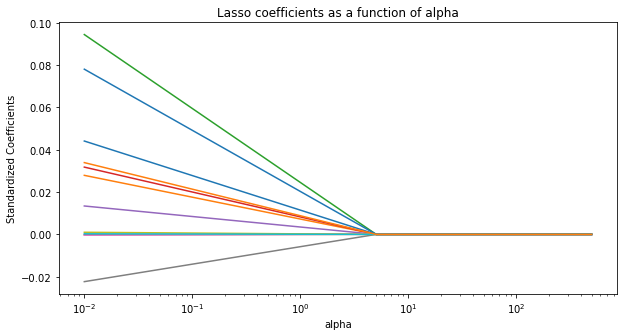

In [50]:
# Plot the lasso coefficients as a function of alpha

alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

Depending on the value of alpha the penalization term l1 changes. The consequence of it is visible in this plot: on the left, for very low value of alpha the model returned by lasso contains all the coefficients with high estimates. As alpha starts to increase the coefficient estimates are shrinked towards zero.

In [51]:
from sklearn import linear_model

alpha_vals = np.linspace(1e-4, 0.5, 500)

# the best value of alpha (lambda) is selected using cross validation
model_lasso = linear_model.LassoCV(n_alphas = len(alpha_vals), alphas=alpha_vals, fit_intercept = True, cv = 10)
# lasso model with the best value of alpha is fitted on the train set
model_lasso.fit(X_train, y_train)
# shrinked coefficients of the lasso model with the best value of alpha 
coefs = model_lasso.coef_.reshape(-1)

lasso_CV_features = []

for ind, num in enumerate(coefs):
    for i, f in enumerate(X_features):
        if num != 0.0 and num != -0.0:
            if ind == i:
                lasso_CV_features.append(f)

print(f'The model selected by CV is: {lasso_CV_features}')

print('R squared training set', round(model_lasso.score(X_train, y_train)*100, 2))
print('R squared test set', round(model_lasso.score(X_test, y_test)*100, 2))

LassoCV(alphas=array([1.00000000e-04, 1.10180361e-03, 2.10360721e-03, 3.10541082e-03,
       4.10721443e-03, 5.10901804e-03, 6.11082164e-03, 7.11262525e-03,
       8.11442886e-03, 9.11623246e-03, 1.01180361e-02, 1.11198397e-02,
       1.21216433e-02, 1.31234469e-02, 1.41252505e-02, 1.51270541e-02,
       1.61288577e-02, 1.71306613e-02, 1.81324649e-02, 1.91342685e-02,
       2.01360721e-02, 2.11378758e-0...
       4.76958517e-01, 4.77960321e-01, 4.78962124e-01, 4.79963928e-01,
       4.80965731e-01, 4.81967535e-01, 4.82969339e-01, 4.83971142e-01,
       4.84972946e-01, 4.85974749e-01, 4.86976553e-01, 4.87978357e-01,
       4.88980160e-01, 4.89981964e-01, 4.90983768e-01, 4.91985571e-01,
       4.92987375e-01, 4.93989178e-01, 4.94990982e-01, 4.95992786e-01,
       4.96994589e-01, 4.97996393e-01, 4.98998196e-01, 5.00000000e-01]),
        cv=10, n_alphas=500)

The model selected by CV is: ['DMC', 'DC']
R squared training set 0.19
R squared test set 0.18


Applying Lasso shrinkage method on the dataset the r2 score of the model with the shrinked coefficients is 0.19% on the training set and 0.18% on the test set. 
The only coefficients that remain different from 0, and so are significant, when the value of lambda is the best one (selected through CV) are: ['DMC', 'DC']

In [52]:
X = fire[X_features].to_numpy()
y = fire['log_area'].to_numpy()
print("X.shape ", X.shape)
print("y.shape ", y.shape)

fire_test_size = 0.3
# the test set will contain the 30% of the total observations present in the original fire dataset
fire_test_seed = 40
# Split X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=fire_test_size, random_state=fire_test_seed)
print("X_train.shape ", X_train.shape)
print("X_test.shape ", X_test.shape)

model = LinearRegression(fit_intercept=True) 
# first I created the linear regression model object
model = model.fit(X_train, y_train) 

i = np.transpose(model.coef_)
r = np.transpose(ridge.coef_)
l = coefs
coefficients = pd.DataFrame({"inital coefficients":np.around(i, decimals=2),"ridge coefficients":np.around(r, decimals=2), "lasso coefficients":l})
coefficients.index = X_features
print(coefficients)

X.shape  (510, 12)
y.shape  (510,)
X_train.shape  (357, 12)
X_test.shape  (153, 12)
       inital coefficients  ridge coefficients  lasso coefficients
X                     0.04                0.04            0.000000
Y                     0.03                0.03            0.000000
month                 0.10                0.10            0.000000
day                   0.04                0.04            0.000000
FFMC                  0.01                0.01            0.000000
DMC                  -0.00               -0.00           -0.000423
DC                   -0.00               -0.00            0.000280
ISI                  -0.02               -0.02           -0.000000
temp                  0.00                0.00           -0.000000
RH                    0.00                0.00            0.000000
wind                  0.08                0.08            0.000000
rain                  0.12                0.09            0.000000


In the table above the coefficients of the initial linear model fitted on the train set are reported as well as the value of the coefficients shrinked using Ridge approach or Lasso.
We can clearly see that Ridge regularization reduces the impact of the features on the response but never set the coefficients to 0; on the other end Lasso shrinkage method sets as much as possible the parameters to 0 and in fact the best value of lambda, selected through Cross validation, leads to nullify all the coefficients of the model except two of them.

## Conclusions:

using the logarithmic tranformation of area and converting the categorical variables, month and day, in discrete ones I obtained the following results:

- the linear regression model using all the features of the dataset has a r2 score of 3.7% on the train set and of 1% on the test set;
- the best linear regression model is the one with degree 1;
- the best model according with forward feature selection has 0 features (dummy regressor);
- the best model according with forward feature selection with cross validation (and backward feature selection) has 3 features: ['X', 'month', 'wind'];
- the linear model with the selected features ['X', 'month', 'wind'] has a r2 score on the train set of 2.7% and on the test set of 1.8%. With this features the best linear model is the one with degree 1;
- the linear model with Ridge shrinked coefficients has a r2 score of 4% on the train set and 1% on the test set;
- the linear model with Lasso shrinked coefficients has a r2 score of 0.19% on the train set and 0.18% on the test set: the only two coefficients different from 0 are ['DMC', 'DC'].


I repeated all the commands above on the same dataset with different pre-processing steps to look for an improvement of the linear regression model performance.

# one-hot encoding of categorical variable day

I tried to see if, by converting the categorical variables in dummy ones, the performace of the fitted linear model would improve. 
Indeed I saw that by converting both of them the result was not good on the test set, so I decided to convert only day in dummy variable keeping month as discrete one.

Pre-processing steps:

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import scipy

fire = pd.read_csv("forestfires.csv")
fire = fire.replace('Missing',np.nan).dropna()

fire = fire.astype({"FFMC": float})
fire = fire.astype({"DC": float})
fire = fire.astype({"ISI": float})
fire = fire.astype({"wind": float})
fire = fire.astype({"temp": float})

fire['log_area'] = np.log1p(fire['area'])
fire = fire.drop(['area'],axis=1)

In [54]:
def onehot_feature(pd_data, column_name):
    # Retrieve the unique values (the categories) and an index for each sample
    # specifying the sample category (values[value_idx] reconstruct the original array)
    col_values = pd_data[column_name].to_numpy().astype('<U')
    values, value_idx = np.unique(col_values, return_inverse=True)
    n_values = values.size
    # Create a temporary identity matrix to convert value_idx into one-hot features
    onehots = np.eye(n_values,n_values)
    value_onehot = onehots[value_idx]
    # Remove the categorical feature
    pd_data = pd_data.drop(column_name, axis=1)
    # Add the new featues
    for i in range(n_values):
        pd_data["{}_{}".format(column_name, values[i])] = value_onehot[:, i]
        
    return pd_data

# Convert day into a one-hot encoding
fire = onehot_feature(fire, 'day')

In [55]:
fire['month'] = fire['month'].replace(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],range(1,13))

In [56]:
fire.shape

(510, 19)

After these pre-processing steps I performed the same analysis as before obtaining:

- the linear model using all the features of the dataset has a r2 score of 4% on the train set and of 1.7% on the test set;
- from the t- test none coefficient is significantly different from 0 and the same result is returned by F-test;
- the best linear model is the one with degree 1;
- the best model according with forward feature selection has 0 features;
- the best model according with forward feature selection with cross validation (and also backword feature selection) has 3 features: ['X', 'month', 'wind'];
- the linear model with the features ['X', 'month', 'wind'] has a r2 score on the train set of 2.7% and on the test set of 1.8%. With this features the best linear model is the one with degree 1;
- the linear model with Ridge shrinked coefficients has a r2 score of 4% on the training set and 2% on the test set;
- the linear model with Lasso shrinked coefficients has a r2 score of 0.19% on the training set and 0.18% on the test set: the only two coefficients different from 0 are the ones of ['DMC', 'DC'].


## Logarithmic transformation of area,  FFMC, ISI and rain variables 

Since these four variables are the ones that present a small percentage of observations with a very high or low value with respect to all the other values of the same variable, I thought to do a logarithmic transformation not only of the variable area but also of these other three to try to understand if, reducing their skweness, there is an improvement in the performance of the linear regression model.

The pre-processing steps I performed before using the same workflow of analysis were:

In [57]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import scipy

np.random.seed(0)

fire = pd.read_csv("forestfires.csv")

fire = fire.replace('Missing',np.nan)
fire = fire.dropna()

fire = fire.astype({"FFMC": float})
fire = fire.astype({"DC": float})
fire = fire.astype({"ISI": float})
fire = fire.astype({"wind": float})
fire = fire.astype({"temp": float})

fire['log_area'] = np.log1p(fire['area'])
fire = fire.drop(['area'],axis=1)
fire['log_FFMC'] = np.log1p(fire['FFMC'])
fire = fire.drop(['FFMC'],axis=1)
fire['log_rain'] = np.log1p(fire['rain'])
fire = fire.drop(['rain'],axis=1)
fire['log_ISI'] = np.log1p(fire['ISI'])
fire = fire.drop(['ISI'],axis=1)

def onehot_feature(pd_data, column_name):
    # Retrieve the unique values (the categories) and an index for each sample
    # specifying the sample category (values[value_idx] reconstruct the original array)
    col_values = pd_data[column_name].to_numpy().astype('<U')
    values, value_idx = np.unique(col_values, return_inverse=True)
    n_values = values.size
    # Create a temporary identity matrix to convert value_idx into one-hot features
    onehots = np.eye(n_values,n_values)
    value_onehot = onehots[value_idx]
    # Remove the categorical feature
    pd_data = pd_data.drop(column_name, axis=1)
    # Add the new featues
    for i in range(n_values):
        pd_data["{}_{}".format(column_name, values[i])] = value_onehot[:, i]
        
    return pd_data

# Convert day into a one-hot encoding
fire = onehot_feature(fire, 'day')

In [58]:
fire['month'] = fire['month'].replace(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],range(1,13))

In [59]:
fire.shape

(510, 19)

After the pre-processing steps the same analysis was performed with the following results:
    
- the linear model using all the features of the dataset has a r2 score of 3.7% on the train set and of 2% on the test set;
- from the t- test none coefficient is significantly different from 0 and the same result is returned by F-test;
- the best linear model is the one with degree 1;
- the best model according with forward feature selection has 0 features;
- the best model according with forward feature selection with cross validation (and backward feature selection) has 3 features: ['X', 'month', 'wind'];
- the linear model with the features ['X', 'month', 'wind'] has a r2 score on the train set of 2.7% and on the test set of 1.8%. With this features the best linear model is the one with degree 1;
- the linear model with Ridge shrinked coefficients has a r2 score of 3% on the training set and 2% on the test set;
- the linear model with Lasso shrinked coefficients has a r2 score of 0.19% on the training set and 0.18% on the test set: the only two coefficients different from 0 are the ones of ['DMC', 'DC'].


# Standardization of the variables

Since the performance of the process of learning from the data is generally better when the features are standardized on the same scale, I performed this pre-processing procedure to understand if there is actually an improvement of the linear regression model in predicting the area.

In particular, the standardization was performed after having seen from the summary of the main descriptive statistics of the quantitative variables of the dataset that there was a great difference of scale between the different features. 

In [60]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import scipy

np.random.seed(0)

fire = pd.read_csv("forestfires.csv")

fire = fire.replace('Missing',np.nan)
fire = fire.dropna()

fire = fire.astype({"FFMC": float})
fire = fire.astype({"DC": float})
fire = fire.astype({"ISI": float})
fire = fire.astype({"wind": float})
fire = fire.astype({"temp": float})

fire['log_area'] = np.log1p(fire['area'])
fire = fire.drop(['area'],axis=1)

def onehot_feature(pd_data, column_name):
    # Retrieve the unique values (the categories) and an index for each sample
    # specifying the sample category (values[value_idx] reconstruct the original array)
    col_values = pd_data[column_name].to_numpy().astype('<U')
    values, value_idx = np.unique(col_values, return_inverse=True)
    n_values = values.size
    # Create a temporary identity matrix to convert value_idx into one-hot features
    onehots = np.eye(n_values,n_values)
    value_onehot = onehots[value_idx]
    # Remove the categorical feature
    pd_data = pd_data.drop(column_name, axis=1)
    # Add the new featues
    for i in range(n_values):
        pd_data["{}_{}".format(column_name, values[i])] = value_onehot[:, i]
        
    return pd_data

# Convert day into a one-hot encoding
fire = onehot_feature(fire, 'day')

In [61]:
fire['month'] = fire['month'].replace(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],range(1,13))

In [62]:
X_features = fire.columns.to_list()
# list of all the features in the fire dataset 
X_features.remove('log_area')

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

X = fire[X_features].to_numpy()
y = fire['log_area'].to_numpy()
print("X.shape ", X.shape)
print("y.shape ", y.shape)

fire_test_size = 0.3
# the test set will contain the 30% of the total observations present in the original fire dataset
fire_test_seed = 40
# Split X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=fire_test_size, random_state=fire_test_seed)
print("X_train.shape ", X_train.shape)
print("X_test.shape ", X_test.shape)

# Standardization procedure
sc = StandardScaler() 
sc.fit(X_train)
X_train_std = sc.transform(X_train) 
X_test_std = sc.transform(X_test)  

X.shape  (510, 18)
y.shape  (510,)
X_train.shape  (357, 18)
X_test.shape  (153, 18)


StandardScaler()

After this pre-processing procedure the same workflow was computed giving the following results:

- the linear model using all the features of the dataset has a r2 score of 4% on the train set and of 1.8% on the test set;
- from the t- test none coefficient is significantly different from 0 and the same result is returned by F-test;
- the best linear model is the one with degree 1;
- the best model according with forward feature selection has 0 features;
- the best model according with forward feature selection with cross validation (and backward feature selection) has 3 features: ['X', 'month', 'wind'];
- the linear model with the features ['X', 'month', 'wind'] has a r2 score on the train set of 2.7% and on the test set of 1.8%. With this features the best linear model is the one with degree 1;
- the linear model with Ridge shrinked coefficients has a r2 score of 4% on the training set and 2% on the test set;
- the linear model with Lasso shrinked coefficients has a r2 score of 0.19% on the training set and 0.18% on the test set: the only two coefficients different from 0 are the ones of ['DMC', 'DC'].


# Conclusion

In conclusion of my analysis I can say that the linear regression model doesn't have a good performance in predicting the area of the fire using the other variables present into the ForestFire dataset.

Here a brief summary of the workflow I executed: first, I performed different pre-processing procedures, all implying the logarithmic transformation of the response variable area - categorical variables converted in discrete ones; one-hot encoding of day variable keeping month discrete; logarithmic transformation of FFMC, ISI and rain variables; standardization of all the quantitative variables of the dataset.
Then I splitted the data in train and test set, I used the train set to fit a linear regression model and the test set to compute its performance. 
I also performed the t-test and F-test on the coefficients of the model to verify if they were significantly different from 0; I analysed for which degree the linear regression model permormed the best.
I proceeded with forward and backward feature selection with Cross Validation and by the end with Lasso and Ridge shrinkage methods.

Independently from the pre-processing procedure I performed, the fitted linear regression model didn't seem to be able to explain a great percentage of variability of never seen data.


In [64]:
fire.log_area.value_counts()

0.000000    240
1.078410      3
2.394252      2
0.518794      2
0.357674      2
           ... 
1.564441      1
0.802002      1
1.166271      1
1.244155      1
1.190888      1
Name: log_area, Length: 251, dtype: int64

Probably, the fact that half of values of the variable log_area are 0 and that only few of tham have high values makes difficult to predict the dimension of the fire using a linear multivariate regression model.
Some other techniques, like the one used in the reference article - Support Vector Machine -, may work better in predicting the burnt area using these features at disposal.